In [1]:
import ramanspy as rp
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import random
import os
import glob
from scipy.signal import find_peaks

random.seed(12345)

In [4]:
## To import 2D or 3D Raman maps
map_type='3D'
pattern_3D="FG19-101-C-50X-TL-3D_49mw--Scan LA--*--Spec.Data 1.mat" ## This is if doing 3D, the asterisk should be for whatever the layer number is (the only unrepeated part of the filenames)
slice_key_2D='XY' ## If doing 2D select the slice you want to look at

data_folder = os.getcwd() #Change this to wherever the layers are stored, or just put the notebook in the folder.

if map_type=='2D':
    mat_files = glob.glob(os.path.join(data_folder, '*.mat'))
    if not mat_files:
        print("Error: No files found. Check folder path and file format")
    else:
        selected_slice= [k for k in mat_files if slice_key_2D in k][0]
        map_2D=rp.load.witec(selected_slice)
        print(map_type+" Mode")
        print(selected_slice)
        print('Loaded '+slice_key_2D+ ' map')

elif map_type=='3D':
    file_pattern = os.path.join(data_folder, pattern_3D)
    image_layer_files = sorted(glob.glob(file_pattern))
    print(map_type+" Mode")
    for file_path in image_layer_files:
        print(file_path)
    if not image_layer_files:
        print("Error: No files found. Check folder path and pattern")
    else:
        raman_image_stack = [rp.load.witec(image_layer_file) for image_layer_file in image_layer_files]
        volume = rp.SpectralVolume.from_image_stack(raman_image_stack)
        print("Spectral Volume created")

3D Mode
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--019--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--020--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--021--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--022--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--023--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--024--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL-3D_49mw--Scan LA--025--Spec.Data 1.mat
/Users/cljd/Documents/Parallels_files/MAPPINGFG19-101_07012025/101-C_3D/FG19-101-C-50X-TL

## Step 2. Preprocess the whole raman object (baseline, despike, denoise, normalize)

In [5]:
if map_type=='2D':
    raman_object=map_2D
elif map_type=='3D':
    raman_object=volume
else:
    print("Error: check map_type")

########Preprocess the whole raman_object
preprocessing_pipeline_1800g = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
    rp.preprocessing.baseline.ASLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])
preprocessing_pipeline_300g = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.ASLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])
preprocessed_raman_object = preprocessing_pipeline_300g.apply(raman_object)

### View the results of the pre-processing and look at individual spectra

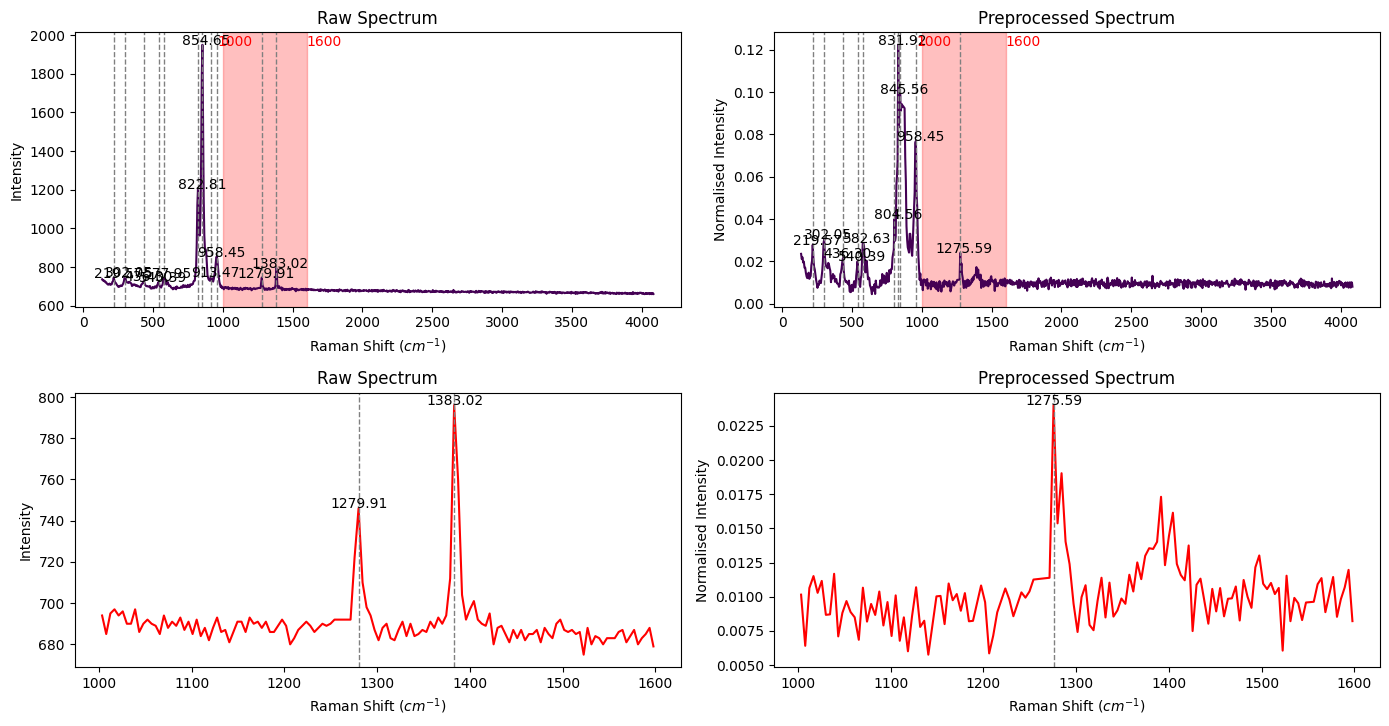

In [6]:
############ Pick spectrum indices to plot in two dimensions (applies to 2D and 3D) ###############
selected_spectrum_2Dindex = (7, 7)

############ For 3D, pick image layer, it will turn 2D index and layer to 3D spectrum index ###############
selected_image_layer = 5
selected_spectrum_3Dindex = (selected_spectrum_2Dindex[0],selected_spectrum_2Dindex[1], selected_image_layer)

############ Crop size for the zoom in spectra at bottom ################
x1=1000#1275
x2=1600#1293

############ Peak prominence plotting filter ############################
raw_prom_filter=20
pp_prom_filter=0.01

##########################
if map_type=='2D':
    selected_spectrum_index=selected_spectrum_2Dindex
elif map_type=='3D':
    selected_spectrum_index=selected_spectrum_3Dindex
else:
    print("Error: check map_type")

#### Create the figure#######################
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

#### First plot the whole spectra in the top two subplots
rp.plot.spectra(raman_object[selected_spectrum_index],ax=axs[0,0], title="Raw Spectrum")
axs[0,0].set_ylabel("Intensity")
axs[0,0].set_xlabel("Raman Shift ($cm^{-1}$)")

rp.plot.spectra(preprocessed_raman_object[selected_spectrum_index], ax=axs[0,1], title="Preprocessed Spectrum")
axs[0,1].set_ylabel("Normalised Intensity")
axs[0,1].set_xlabel("Raman Shift ($cm^{-1}$)")


## FInd the peaks and plot them on the two subplots on top
## There is a ramanspy function but it always plots the labels wrong, it's not easy to manipulate the position of the peak labels.
def plot_peaks(spectral_data, spectral_axis, prominence, ax,peak_label_pos=1):
    peak_indices, _ = find_peaks(spectral_data, prominence=prominence)
    peak_wavenumbers = spectral_axis[peak_indices]
    peak_intensities = spectral_data[peak_indices]
    for wavenumber, intensity in zip(peak_wavenumbers, peak_intensities):
        ax.axvline(x=wavenumber, color='gray', linestyle='--', linewidth=1)
        ax.text(wavenumber + peak_label_pos, intensity, f'{wavenumber:.2f}', ha='center')
    return peak_wavenumbers, peak_intensities

processed_peaks = plot_peaks(preprocessed_raman_object[selected_spectrum_index].spectral_data, preprocessed_raman_object[selected_spectrum_index].spectral_axis, pp_prom_filter, axs[0,1],peak_label_pos=30)
raw_peaks = plot_peaks(raman_object[selected_spectrum_index].spectral_data, raman_object[selected_spectrum_index].spectral_axis, raw_prom_filter, axs[0,0],peak_label_pos=30)

## To show a specific range in color
color='red'

axs[0,0].axvspan(x1, x2, alpha=0.25, color=color, zorder=0)
axs[0,0].text(x1-40, .95, x1, transform=axs[0,0].get_xaxis_transform(),color=color)
axs[0,0].text(x2, .95, x2, transform=axs[0,0].get_xaxis_transform(),color=color)

axs[0,1].axvspan(x1, x2, alpha=0.25, color='red', zorder=0)
axs[0,1].text(x1-40, .95, x1, transform=axs[0,1].get_xaxis_transform(),color=color)
axs[0,1].text(x2, .95, x2, transform=axs[0,1].get_xaxis_transform(),color=color)


################ Now display the cropped regions in the two bottom plots
cropped_raw = rp.preprocessing.misc.Cropper(region=(x1, x2)).apply(raman_object[selected_spectrum_index])
cropped_preprocessed = rp.preprocessing.misc.Cropper(region=(x1, x2)).apply(preprocessed_raman_object[selected_spectrum_index])

rp.plot.spectra(cropped_raw, ax=axs[1,0], title="Raw Spectrum",color=color)
axs[1,0].set_ylabel("Intensity")
axs[1,0].set_xlabel("Raman Shift ($cm^{-1}$)")

rp.plot.spectra(cropped_preprocessed, ax=axs[1,1], title="Preprocessed Spectrum",color=color)
axs[1,1].set_ylabel("Normalised Intensity")
axs[1,1].set_xlabel("Raman Shift ($cm^{-1}$)")
# ## Plot the peaks
plot_peaks(cropped_raw.spectral_data, cropped_raw.spectral_axis, raw_prom_filter, axs[1,0])
plot_peaks(cropped_preprocessed.spectral_data, cropped_preprocessed.spectral_axis, pp_prom_filter, axs[1,1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
nfindr = rp.analysis.unmix.NFINDR(n_endmembers=2, abundance_method='fcls')
abundance_maps, endmembers = nfindr.apply(preprocessed_raman_object)

AttributeError: module 'scipy.linalg' has no attribute '_flinalg'

In [72]:
nfindr = rp.analysis.unmix.NFINDR(n_endmembers=4, abundance_method='fcls')
abundance_maps, endmembers = nfindr.apply(preprocessed_raman_object)


ax = rp.plot.spectra(endmembers, wavenumber_axis=preprocessed_raman_object.spectral_axis, plot_type='single stacked')

selected_indices = [0, 1,2,3]
labels_ = ['0', '1','2','3']

selected_endmembers = [endmembers[i] for i in selected_indices]
selected_abundances = [abundance_maps[i] for i in selected_indices]

AttributeError: module 'scipy.linalg' has no attribute '_flinalg'

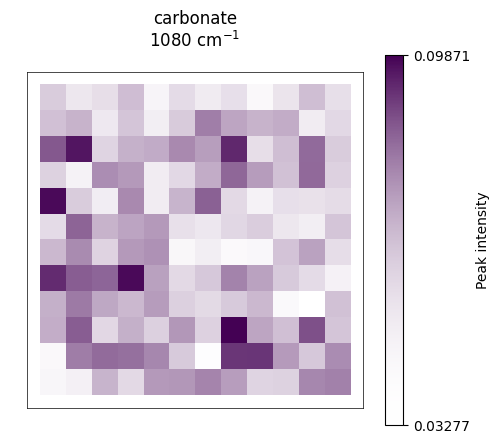

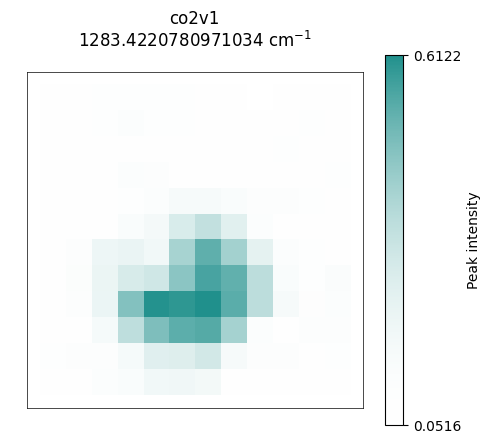

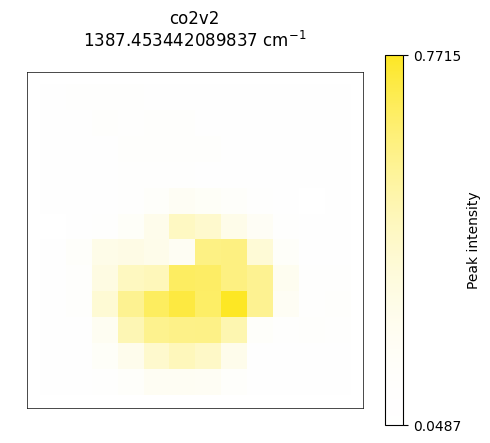

In [ ]:
## Bands could be different between maps, this is just for 1800g map of a CO2 bubble.
#### This will also be used to show the maps later
bands = [1080, processed_peaks[0][0], processed_peaks[0][1]]
band_components = ['carbonate', 'co2v1', 'co2v2']
labels = [f'{comp}\n{band} cm$^{{{-1}}}$' for band, comp in zip(bands, band_components)]

selected_image_layer = 4
ax=rp.plot.image([preprocessed_volume.layer(selected_image_layer).band(band) for band in bands], title=labels)

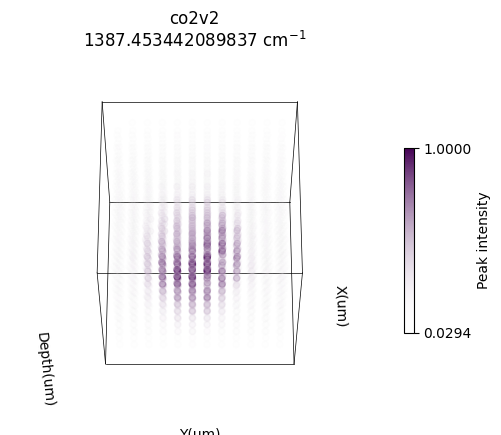

In [22]:
# axs = rp.plot.volume([preprocessed_volume.band(band) for band in bands], title=labels)
axs = rp.plot.volume([preprocessed_volume.band(bands[2])], title=labels[2],zlabel='Depth(um)',xlabel='X(um)',ylabel='Y(um)')

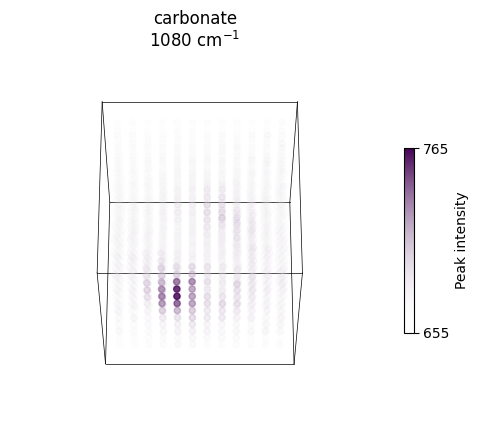

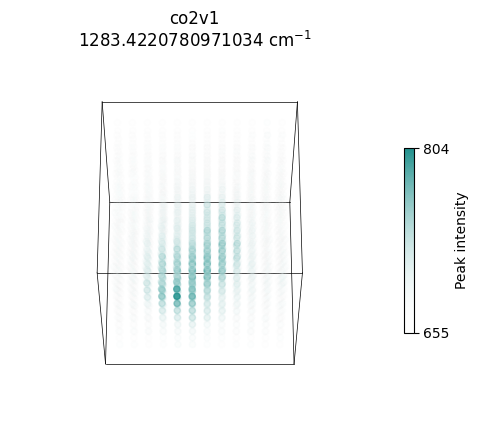

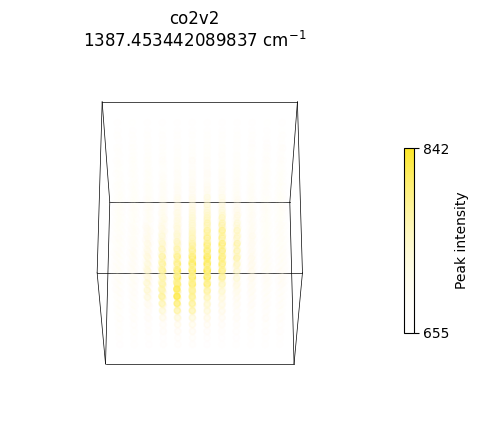

In [7]:
axs = rp.plot.volume([volume.band(band) for band in bands], title=labels)

## Component finder and demixer

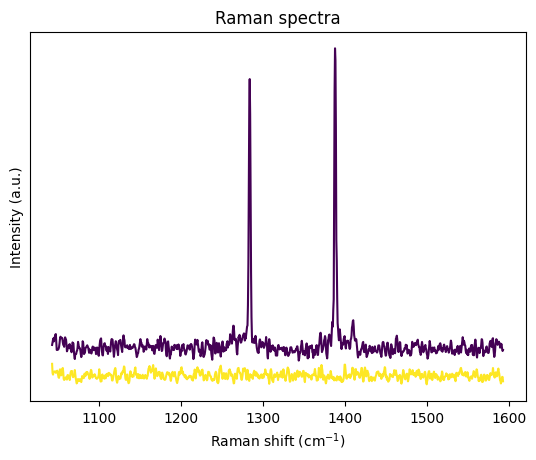

In [8]:
nfindr_unmixer = rp.analysis.unmix.NFINDR(n_endmembers=2)
abundance_maps, endmembers = nfindr_unmixer.apply(preprocessed_volume)


ax = rp.plot.spectra(endmembers, wavenumber_axis=preprocessed_volume.spectral_axis, plot_type='single stacked')

selected_indices = [0, 1]
labels_ = ['CO2', 'Background']

selected_endmembers = [endmembers[i] for i in selected_indices]
selected_abundances = [abundance_maps[i] for i in selected_indices]

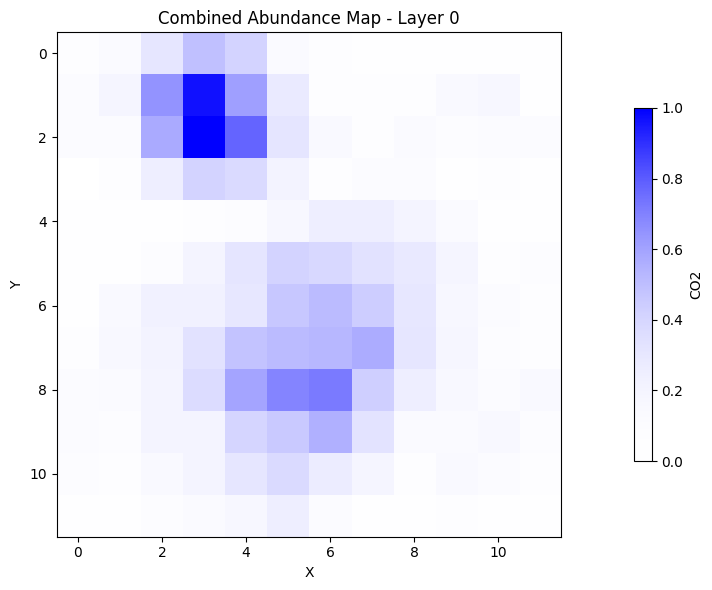

In [72]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import io
from PIL import Image
selected_image_layer = 0

fig, ax = plt.subplots(figsize=(8, 6))

cmap=plt.colormaps.get_cmap('viridis')(np.linspace(0, 1, len(selected_abundances))) #based on viridis, this is the default
cmap=[(0, 0, 1, 1), (0.7, 0.7, 0.7, 1)] # Custom colors

white=(1,1,1,0)

order = ['CO2'] # Define the order of plotting 'Background'
cmap_dict = {}

for label in order:
    i = labels_.index(label)
    cmap_i=LinearSegmentedColormap.from_list('', [white, cmap[i]])
    cmap_dict[label] = cmap_i
    ax.imshow(selected_abundances[i][..., selected_image_layer], cmap=cmap_i)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_i, norm=mcolors.Normalize(vmin=0, vmax=1)), ax=ax, orientation='vertical', label=label, shrink=0.7, pad=0.1)

ax.set_title(f'Combined Abundance Map - Layer {selected_image_layer}')
ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.tight_layout()
plt.show()

# # New: Render figure to buffer and save as image
# fig.canvas.draw()
# rgba_buffer = fig.canvas.buffer_rgba() # Fix: Use buffer_rgba() instead of tostring_rgba()
# width, height = fig.canvas.get_width_height()
# image_array = np.asarray(rgba_buffer) # np.asarray() can directly handle memoryview
# img_pil = Image.fromarray(image_array)
# output_filename = 'combined_abundance_map.bmp'
# img_pil.save(output_filename)

In [29]:
preprocessed_volume.__dict__.keys()

dict_keys(['spectral_data', 'spectral_axis'])

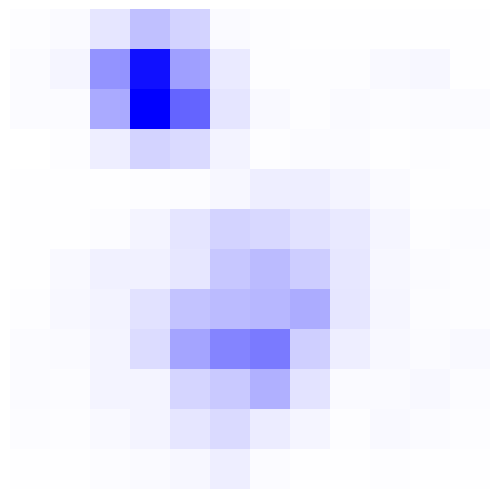

In [73]:
selected_image_layer = 0
plt.imshow(selected_abundances[0][..., selected_image_layer], cmap=LinearSegmentedColormap.from_list('', [white, cmap[0]]))
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig(f"Layer {selected_image_layer}", bbox_inches = 'tight', pad_inches = 0)
plt.show()

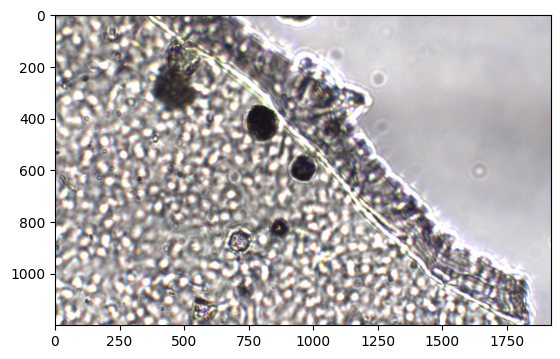

In [44]:
bmp_image_path = "P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\Fi_standards\Polishing_series_062025\Polishseries_062425\Maps\B23_FI5_1_50X_premap.bmp" 
img = Image.open(bmp_image_path)
# Convert image to a NumPy array for plotting
img_array = np.array(img)

# If your BMP has an alpha channel (transparency), you might want to use it.
# Otherwise, simply plotting it will overlay it.
# Since you said the size is the same, matplotlib will overlay them correctly.
plt.imshow(img_array)


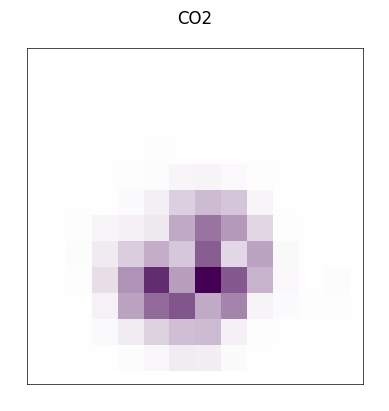

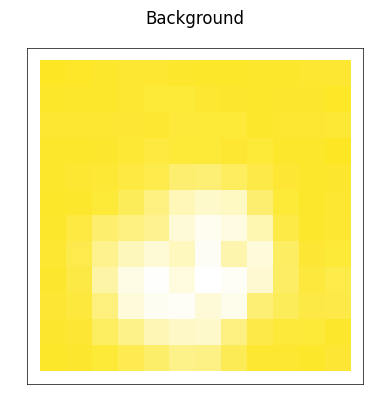

In [146]:
axs = rp.plot.image([abundance_map[..., selected_image_layer] for abundance_map in selected_abundances], title=labels_, cbar=False)

C:\Users\charl\AppData\Local\Temp\ipykernel_34804\3527601650.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))


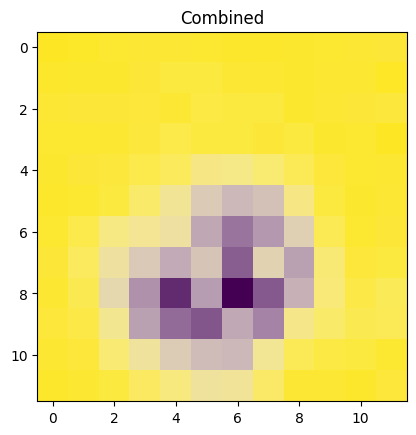

In [145]:
selected_image_layer=5
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap()(np.linspace(0, 1, len(selected_abundances)))

white = [1, 1, 1, 0]

order = ['Background', 'CO2']
for label in order:
    i = labels_.index(label)
    ax.imshow(selected_abundances[i][..., selected_image_layer], cmap=LinearSegmentedColormap.from_list('', [white, cmap[i]]))

ax.set_title('Combined')

plt.show()

In [ ]:
preprocessed_volume.spectral_data[0]

array([[0.04436399, 0.07392017, 0.08166389, ..., 0.07730506, 0.06971028,
        0.03871607],
       [0.05955763, 0.05646553, 0.05654635, ..., 0.072657  , 0.05792186,
        0.03049605],
       [0.11666466, 0.06363028, 0.04827144, ..., 0.06941088, 0.07841421,
        0.08721981],
       ...,
       [0.10013466, 0.05999733, 0.0529744 , ..., 0.06903472, 0.06733999,
        0.06128236],
       [0.08261698, 0.07440662, 0.07928343, ..., 0.0572641 , 0.05617782,
        0.04775448],
       [0.08540308, 0.09598576, 0.09903312, ..., 0.06136063, 0.05190185,
        0.0347095 ]], dtype=float32)